In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PyTorch関係
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

ImportError: /usr/local/lib/python3.10/dist-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkComplete_12_4, version libnvJitLink.so.12

ニューラルネットワーク「PyTorch」の、深層距離学習を行うためのライブラリの1つである
「Pytorch Metric Learning」を利用します。

学習後に各ベクトルがどのクラスに一番近いかを調べて評価できるようにするために
faiss-gpuは「FAISS」(Facebook AI Similarity Search)という近似最近傍探索アルゴリズムのためのライブラリです。
ここで、PyTorch Metric Learning の AccuracyCalculatorクラスを使うためにインストールします。


In [3]:
# 深層距離学習用
from pytorch_metric_learning import distances, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

学習後のベクトル同士の距離関係を2次元で可視化するためのアルゴリズム「t-SNE」を使えるようにする
Pythonの機会学習ライブラリである「scikit-learn」にはt-SNEを実行するためのクラスがありますが、データサイズが大きいと処理が非常に遅くなります。そこでその代わりに「t-SNE-CUDA」というライブラリを入れます。GPUも使うことで、高速にt-SNEを実行できるようになります。

In [4]:
# 可視化用
#from sklearn.manifold import TSNE # 遅い
from tsnecuda import TSNE # 高速

In [5]:
# 用いるデバイスを変数へ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda:0


# 「MNIST」と呼ばれる、0から9の手書き数字のデータセットを使って深層距離学習を行ってみましょう

まず、データを読み込みます。学習用に6万枚、テスト用に1万枚の画像が、それぞれdataset1およびdataset2としてダウンロードされます。

In [12]:
# データセットの準備
transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# データセットの用意（初回はダウンロードされる）
dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, transform=transform)


学習時にバッチ単位（ここでは256枚ずつ）でデータを読み込むことで
ニューラルネットをミニバッチで学習できるように、`DataLoader`クラスのインスタンス（`train_loader`）を用意します。

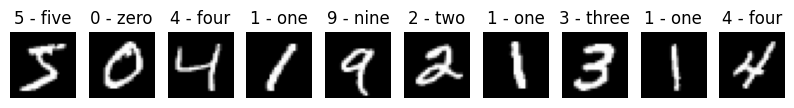

In [13]:
batch_size = 256 # バッチサイズ

# PyTorchの DataLoaderへ
train_loader = torch.utils.data.DataLoader(
  dataset1, batch_size=batch_size, shuffle=True
)

# 学習用画像を10枚表示してみる
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
  ax[i].imshow(np.array(dataset1[i][0].permute(1,2,0)), cmap='gray')
  ax[i].set_title(dataset1.classes[dataset1[i][1]])
  ax[i].axis('off')
plt.show()

## 深層距離学習の実行

画像エンコーダーは*E*という関数で表現します。画像エンコーダー*E*による画像のベクトル空間への埋め込みは
$z=E(I)$ と表現され、画像*I*が入力されると、特徴ベクトル*z*へと変換します。

画像エンコーダー*E*は、ここでは2つの畳み込み層と1つの全結合層を持つ、単純な畳み込みニューラルネット（CNN）を用いることにする

forward() が実際に入力画像に対して行われる処理（順伝播）で、784ピクセル（＝縦28ピクセル×横28ピクセル）の画像データの入力を、
畳み込み層で画像特徴を抽出しつつ、全結合層`fc1`通過後は128次元の画像特徴ベクトル*z*に変換します。

In [14]:
# 2層の畳み込み層を持つ単純なCNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

In [15]:
def train(model, loss_func, device, train_loader, optimizer, epoch):
  model.train() # 訓練モードへ
  for batch_idx, (data, labels) in enumerate(train_loader):
    data, labels = data.to(device), labels.to(device) # GPUへ
    optimizer.zero_grad() # いったん勾配をリセット
    embeddings = model(data) # 順伝播
    loss = loss_func(embeddings, labels) # 損失計算
    loss.backward() # 誤差逆伝播
    optimizer.step() # パラメータ更新
    if batch_idx % 20 == 0:
      print(f'Epoch {epoch} Iteration {batch_idx}: Loss = {loss}')

In [16]:
# すべてのデータを埋め込む
def get_all_embeddings(dataset, model):
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset, model)

# 評価値計算用（1-NNで分類して精度を評価）
accuracy_calculator = AccuracyCalculator(include=('precision_at_1',), k=1)

# accuracy_calculatorを使ってモデルを評価
def test(train_set, test_set, model, accuracy_calculator):
  # 特徴ベクトル（埋め込み）を計算
  train_embeddings, train_labels = get_all_embeddings(train_set, model)
  test_embeddings, test_labels = get_all_embeddings(test_set, model)
  train_labels = train_labels.squeeze(1)
  test_labels = test_labels.squeeze(1)
  print('Computing accuracy') # 精度を計算
  accuracies = accuracy_calculator.get_accuracy(
    test_embeddings, test_labels, train_embeddings, train_labels, False
  )
  print(f'Test set accuracy (Precision@1) = {accuracies["precision_at_1"]}')
  # 埋め込んだ特徴ベクトルをnumpy ndarrayでreturn
  return train_embeddings.detach().cpu().numpy(), \
    train_labels.detach().cpu().numpy(), \
    test_embeddings.detach().cpu().numpy(), \
    test_labels.detach().cpu().numpy()

In [17]:
num_epochs = 1 # エポック数

model = Net().to(device) # モデル初期化
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 訓練とテスト
for epoch in range(1, num_epochs + 1):
  train(model, losses.NTXentLoss(), device, train_loader, optimizer, epoch)
  train_embeddings, train_labels, test_embeddings, test_labels = test(
    dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 5.122315883636475
Epoch 1 Iteration 20: Loss = 2.103205919265747
Epoch 1 Iteration 40: Loss = 1.736659288406372
Epoch 1 Iteration 60: Loss = 1.5530561208724976
Epoch 1 Iteration 80: Loss = 1.097630262374878
Epoch 1 Iteration 100: Loss = 1.0369008779525757
Epoch 1 Iteration 120: Loss = 0.7789475917816162
Epoch 1 Iteration 140: Loss = 0.9422711730003357
Epoch 1 Iteration 160: Loss = 0.9585829377174377
Epoch 1 Iteration 180: Loss = 0.6376255750656128
Epoch 1 Iteration 200: Loss = 0.6381232142448425
Epoch 1 Iteration 220: Loss = 0.7511019110679626


100%|██████████| 313/313 [00:04<00:00, 69.03it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9873000000000001


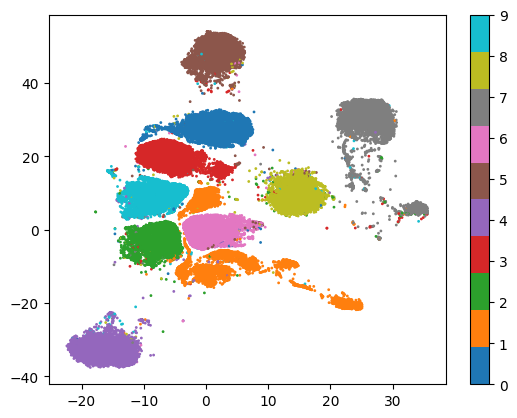

In [18]:
# 2次元で可視化（あくまで参考）
values = TSNE(n_components=2).fit_transform(train_embeddings)
plt.scatter(values[:, 0], values[:, 1], s=1, c=train_labels, cmap='tab10')
plt.colorbar()
plt.show()